In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.downloader as api
from gensim.models.fasttext import load_facebook_model
import random
from difflib import SequenceMatcher
from scipy import stats
import sacrebleu
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import spacy
import re
import edist.sed as sed
from sacremoses import MosesTokenizer, MosesDetokenizer
from sklearn.metrics import matthews_corrcoef

import sys  
sys.path.insert(0, '../')

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


### Align different translations, find which words affect the translation of which words


**Note**: can use [sequence alignments](https://stackoverflow.com/questions/5055839/word-level-edit-distance-of-a-sentence) to align the sentences on the target side only. ([code](https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5))

Pros: could be easier than SRC-TGT alignment

Cons: in the case where more output different sentence structure yet same meaning. <br>
E.g., "Today I think the cat is nice" -- "I think the cat is nice today"
SRC-TGT alignment would probably see these as the same, but edit distance cannot, bc it only has del, insert, substitute operations.


Provided in functions `analyse_single_sentence_single_perturbed_word()` and  `analyse_single_sentence`

# Quality analysis

- Have to use WMT21 data, bc models for 2021 is available. Also they have clear evaluation script
- Have to do some manual fix so that the translation tokenization match completely with the tokenization of the labeled data

### Word-level

- A translated word is uncertain if changing other words in the SRC sentence affect its translations. The assumption is the the translation of one word should only depends on a few others word, but not too many.
    - E.g., My mother, who had a difficult childhood, is a great doctor.
    - The gender form of "doctor" should only change if we change the word "mother".

- Hyperparam: The number of SRC words that effect the translations of the target word
    - Currently: If a translated word has 3 or more effecting SRC word, mark as "BAD"

- Metrics: Matthews correlation coefficient 
    "It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction."
    
- Unsupervised baseline: since our approach is based on the uncertainty of a translated word, the baseline could be the word-level log probablity generated by the NMT model itself. (i.e., word with low certainty --> BAD)

Current score: 0.2825

Score of WMT21 shared task: baseline 0.370, best 0.510

WMT21 baseline: multilingual transformer-based Predictor-Estimator approach for both sentence level and word level


**How to do hyperparameter tuning if our goal is not to use the training data? Or just using the dev set is oke?**



### Baseline
Uses word-level log probablity generated by the NMT model itself. (i.e., word with low certainty --> BAD).

Note that the NMT model output subwords and subword log probs, so for a word `A=a1a2` made of subwords `a1`, `a2`:

prob(a1a2 | things before it, SRC) = prob(a1 | things before it, SRC) *  prob(a2 | a1, things before it, SRC) 

$$log(prob(A)) = log(prob(a1)) + log(prob(a2))$$




Some times it output subwords that contains 2 tokens (i.e., the opposite of the above case). This does not happen very often

Then we approximate:
$$log(prob(a1)) = log(prob(a2)) = log(prob(A))/2$$

**Is this correct???**



Current best hyperparams setting on dev en-de:

Our approach: hyperparams: 
- Perturbing [allTokens, allWords, allContentWords*]
- effecting_words_thresholds: [1,2*,3,4]
- consistence_trans_portion_thresholds: [0.6, 0.7, 0.8 0.85 0.9 0.95*]
- uniques_portion_for_noiseORperturbed_thresholds: [0.35 0.4* 0.45, 0.6, 0.8]

Nmt word probas:
- Thresholds [0.4, 0.45*, 0.5, 0.55, 0.6]

#### Word-level QE on translation

- Our perturbation approach:
    
- Use nmt model word probas:
    
    
    
#### Word-level QE on SRC
- Our perturbation approach:
    
- Use nmt model word probas:
    
    
--> Worse than using nmt model word probas

In [2]:
from align_and_analyse_ambiguous_trans import analyse_single_sentence_single_perturbed_word, analyse_single_sentence, align_translations, uniquify
from quality_estimation import nr_effecting_src_words_eval, nmt_log_prob_eval, flatten_list, load_gold_labels, replace_unknown

dataset = 'WMT21_DA_test'
data_root_path = '../data'
src_lang = 'en'
tgt_lang = 'de'
effecting_words_threshold = 2
consistence_trans_portion_threshold = 0.95
uniques_portion_for_noiseORperturbed_threshold = 0.4
nmt_log_prob_threshold = 0.45
task = 'trans_word_level_eval'
perturbed_trans_df_path = f'../analyse_output/{dataset}_{src_lang}2{tgt_lang}_MultiplePerSentence_content/analyse_{dataset}_{src_lang}2{tgt_lang}_MultiplePerSentence_content.pkl'
original_translation_output_dir = f'../output/{dataset}_{src_lang}2{tgt_lang}/original'

perturb_based_pred, perturb_based_details = nr_effecting_src_words_eval(perturbed_trans_df_path, task=task,
                                                 effecting_words_threshold=effecting_words_threshold,
                                                 consistence_trans_portion_threshold=consistence_trans_portion_threshold,
                                                 uniques_portion_for_noiseORperturbed_threshold=uniques_portion_for_noiseORperturbed_threshold,
                                                 return_details=True)
nmt_prob_based_pred = nmt_log_prob_eval(dataset, data_root_path, src_lang, tgt_lang, nmt_log_prob_threshold, perturbed_trans_df_path, task,
                                        original_translation_output_dir)
gold_labels = load_gold_labels(dataset, data_root_path, src_lang, tgt_lang, task)




In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score, f1_score

def report_metrics(pred, gold_labels): 
    labels = ['OK', 'BAD']
    recall = recall_score(flatten_list(gold_labels), 
                          flatten_list(pred), labels=labels, pos_label='BAD')
    precision = precision_score(flatten_list(gold_labels), 
                                flatten_list(pred), labels=labels, pos_label='BAD')
    f1_bad = f1_score(flatten_list(gold_labels), 
                  flatten_list(pred), labels=labels, pos_label='BAD')
    f1_ok = f1_score(flatten_list(gold_labels), 
                  flatten_list(pred), labels=labels, pos_label='OK')

    print(f"Recall wrt BAD: {recall}")
    print(f"Precision wrt BAD: {precision}")
    print(f"F1 wrt BAD: {f1_bad}")
    print(f"F1 wrt OK: {f1_ok}")
    print(f"Matthews_corrcoef: {matthews_corrcoef(flatten_list(gold_labels), flatten_list(pred))}")

    print(f"Percentage of unknown labels: {accuracy_score(flatten_list(pred), ['unknown']*len(flatten_list(gold_labels)))*100}")

    dist = ConfusionMatrixDisplay(confusion_matrix(flatten_list(gold_labels), 
                                                   flatten_list(pred), labels=labels),
                                 display_labels=labels)
    dist.plot()



Recall wrt BAD: 0.45396317053642915
Precision wrt BAD: 0.31265508684863524
F1 wrt BAD: 0.3702857142857143
F1 wrt OK: 0.8530498723663656
Matthews_corrcoef: 0.23551405258725522
Percentage of unknown labels: 0.0


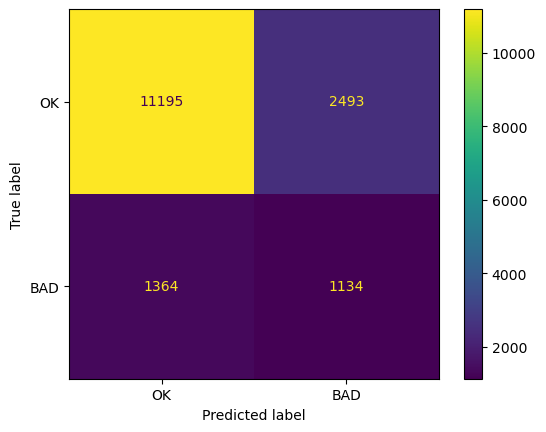

In [4]:
report_metrics(pred=nmt_prob_based_pred, gold_labels=gold_labels)

Recall wrt BAD: 0.5628502802241794
Precision wrt BAD: 0.32085805568233683
F1 wrt BAD: 0.4087209302325581
F1 wrt OK: 0.8404205240859878
Matthews_corrcoef: 0.28085357911703124
Percentage of unknown labels: 0.0


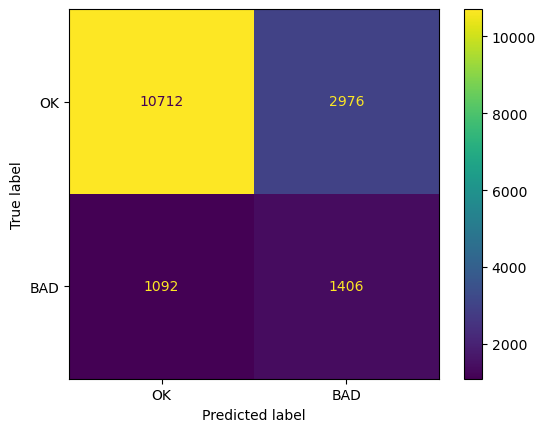

In [5]:
report_metrics(pred=perturb_based_pred, gold_labels=gold_labels)

Looking into the percentage of same predictions between `perturb_based_pred` and `nmt_prob_based_pred` to see if our approach is actually any different.

0.7021 --> actually detecting the same thing

In [6]:
accuracy_score(flatten_list(gold_labels), flatten_list(perturb_based_pred))

0.7486716915853207

Combinining the two classifiers:

Recall wrt BAD: 0.3262610088070456
Precision wrt BAD: 0.3774895785085688
F1 wrt BAD: 0.3500107365256603
F1 wrt OK: 0.8907811654338806
Matthews_corrcoef: 0.24234330037743157
Percentage of unknown labels: 0.0


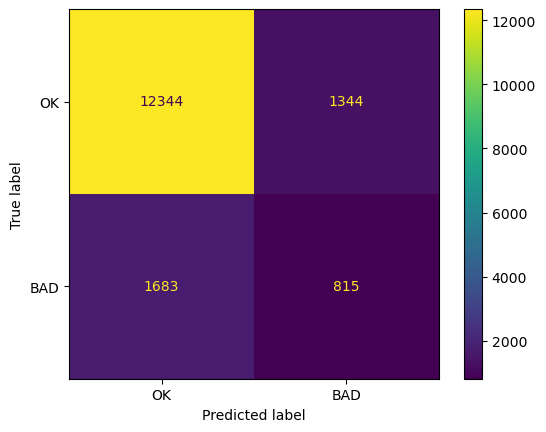

In [7]:
intersec_pred = [[
    'BAD' if i=='BAD' and j=='BAD' else
    'OK' if i=='OK' and j=='OK' else
    'OK' for i,j in zip(x,y)] 
    for x, y in zip(perturb_based_pred, nmt_prob_based_pred)]
 
report_metrics(pred=intersec_pred, gold_labels=gold_labels)

Recall wrt BAD: 0.6905524419535628
Precision wrt BAD: 0.2948717948717949
F1 wrt BAD: 0.41327264015333015
F1 wrt OK: 0.7961205461205461
Matthews_corrcoef: 0.2926696633147187
Percentage of unknown labels: 0.0


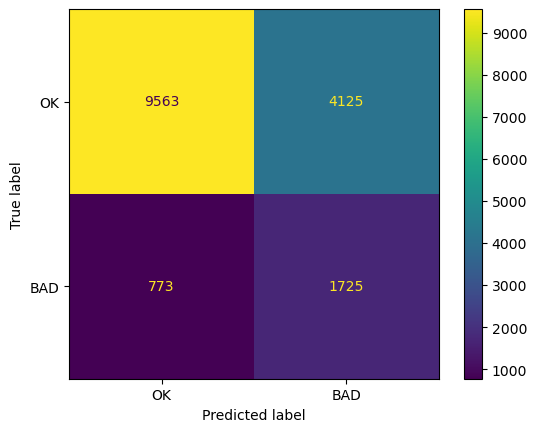

In [8]:
union_pred = [[
    'BAD' if i=='BAD' and j=='BAD' else
    'OK' if i=='OK' and j=='OK' else
    'BAD' for i,j in zip(x,y)] 
    for x, y in zip(perturb_based_pred, nmt_prob_based_pred)]
 
report_metrics(pred=union_pred, gold_labels=gold_labels)

### Analyse some specific samples

In [9]:
perturbed_trans_df = pd.read_pickle(perturbed_trans_df_path)


In [10]:
stop = 1
count = 0
for sentence_idx in range(len(gold_labels)):
    sentence_df = perturbed_trans_df[perturbed_trans_df['SRC_original_idx'] == sentence_idx]
    original_SRC = sentence_df['SRC'].values[0]
    original_translation = sentence_df['SRC-Trans'].values[0]
    tok_original_translation = sentence_df['tokenized_SRC-Trans'].values[0]
    tok_original_SRC = sentence_df['tokenized_SRC'].values[0]

    my_pred = np.array(perturb_based_pred[sentence_idx])
    nmt_pred = np.array(nmt_prob_based_pred[sentence_idx])
    gold = np.array(gold_labels[sentence_idx])


#     # BAD words correctly predicted by perturb_based_pred
#     bad_word_indices = np.nonzero(np.logical_and(my_pred=='BAD', gold=='BAD'))

#     # OK words predicted by perturb_based_pred as BAD
#     bad_word_indices = np.nonzero(np.logical_and(my_pred=='BAD', gold=='OK'))
    
    # BAD words predicted by perturb_based_pred as OK
    bad_word_indices = np.nonzero(np.logical_and(my_pred=='OK', gold=='BAD'))


    # # BAD words correctly predicted by perturb_based_pred, but not by nmt_prob_based_pred
    # bad_word_indices = np.nonzero(np.logical_and(np.logical_and(my_pred=='BAD', gold=='OK'), gold=='BAD'))
    
    if len(bad_word_indices[0]) > 0:
        
        print(len(bad_word_indices[0]))
        count = count + 1
        if count == stop:
            word_idx = bad_word_indices[0][0]
            break



1


In [11]:
# sentence_idx = 0
# sentence_df = perturbed_trans_df[perturbed_trans_df['SRC_original_idx'] == sentence_idx]
# original_SRC = sentence_df['SRC'].values[0]
# original_translation = sentence_df['SRC-Trans'].values[0]
# tok_original_translation = sentence_df['tokenized_SRC-Trans'].values[0]
# tok_original_SRC = sentence_df['tokenized_SRC'].values[0]
# my_pred = np.array(perturb_based_pred[sentence_idx])
# bad_word_indices = np.nonzero(my_pred=='BAD')
# word_idx = bad_word_indices[0][0]

In [12]:
bad_word_indices

(array([8]),)

In [13]:
if task == 'src_word_level_eval':
    word = tok_original_SRC[word_idx]
    align_type = "src-trans"
elif task == 'trans_word_level_eval':
    word = tok_original_translation[word_idx]
    align_type = "trans-only"
else:
    raise RuntimeError()

In [14]:
import pprint


print(f"Original SRC sentence:\n{original_SRC}")
print(f"Original trans:\n{original_translation}")
print(f"BAD word: {word}")
print()

pprint.pprint(analyse_single_sentence(
    sentence_df, align_type=align_type, return_word_index=False,
    consistence_trans_portion_threshold=consistence_trans_portion_threshold,
    uniques_portion_for_noiseORperturbed_threshold=uniques_portion_for_noiseORperturbed_threshold
)[word])


Original SRC sentence:
Figures, Donald's mother Beulah Mae Donald sued the KKK in civil court in Alabama.
Original trans:
ZAHLEN , Donalds Mutter Beulah Mae Donald VERKLAGT DIE KKK vor Gericht in Alabama .
BAD word: die

{'effecting_words': ['sued', 'KKK'],
 'no_effecting_words': ['Donald',
                        'mother',
                        'Beulah',
                        'Mae',
                        'Donald_2',
                        'civil',
                        'court',
                        'Alabama']}


In [15]:
original_word = 'sued'


groups_by_perturbed_word = sentence_df.groupby("SRC_masked_index", as_index=False)
original_words = [group_by_perturbed_word.iloc[0]['original_word']
                  for _, group_by_perturbed_word in groups_by_perturbed_word]
groups_by_perturbed_word = [group_by_perturbed_word for _, group_by_perturbed_word in groups_by_perturbed_word]
original_words = list(uniquify(original_words))


sentence_single_perturbed_word_df = groups_by_perturbed_word[original_words.index(original_word)]


pprint.pprint(analyse_single_sentence_single_perturbed_word(
    sentence_single_perturbed_word_df, align_type=align_type,
    consistence_trans_portion_threshold=consistence_trans_portion_threshold,
    uniques_portion_for_noiseORperturbed_threshold=uniques_portion_for_noiseORperturbed_threshold
))
align_translations(sentence_single_perturbed_word_df, align_type=align_type)


{'perturbed_or_noise_words': ['verklagt'],
 'words_with_consistent_trans': {',': ',',
                                 '.': '.',
                                 'Alabama': 'Alabama',
                                 'Beulah': 'Beulah',
                                 'Donald': 'Donald',
                                 'KKK': 'KKK',
                                 'Mae': 'Mae',
                                 'Mutter': 'Mutter',
                                 'Zahlen': 'Zahlen',
                                 'in': 'in'},
 'words_with_unstable_trans': {'Donalds': {'Donald': 9, 'Donalds': 22},
                               'Gericht': {'Gericht': 21, 'Zivilgericht': 10},
                               'die': {'das': 1, 'dem': 1, 'der': 1, 'die': 28},
                               'vor': {'in': 7, 'vor': 24}}}


,Zahlen,",",Donalds,Mutter,Beulah,Mae,Donald,verklagt,die,KKK,vor,Gericht,in,Alabama,.
sued,Zahlen,",",Donalds,Mutter,Beulah,Mae,Donald,verklagt,die,KKK,vor,Gericht,in,Alabama,.
represented,Zahlen,",",Donald,Mutter,Beulah,Mae,Donald,vertreten,die,KKK,in,Zivilgericht,in,Alabama,.
defended,Zahlen,",",Donalds,Mutter,Beulah,Mae,Donald,verteidigte,die,KKK,vor,Gericht,in,Alabama,.
represents,Zahlen,",",Donald,Mutter,Beulah,Mae,Donald,vertritt,die,KKK,vor,Gericht,in,Alabama,.
challenged,Zahlen,",",Donalds,Mutter,Beulah,Mae,Donald,angefochten,die,KKK,vor,Gericht,in,Alabama,.
representing,Zahlen,",",Donald,Mutter,Beulah,Mae,Donald,vertritt,die,KKK,vor,Gericht,in,Alabama,.
defeated,Zahlen,",",Donalds,Mutter,Beulah,Mae,Donald,besiegte,die,KKK,vor,Gericht,in,Alabama,.
prosecuted,Zahlen,",",Donalds,Mutter,Beulah,Mae,Donald,verfolgt,die,KKK,vor,Gericht,in,Alabama,.
fought,Zahlen,",",Donalds,Mutter,Beulah,Mae,Donald,kämpfte,die,KKK,in,Zivilgericht,in,Alabama,.
joined,Zahlen,",",Donald,Mutter,Beulah,Mae,Donald,trat,der,KKK,in,Zivilgericht,in,Alabama,.


### Finding patterns

In [ ]:
from collections import defaultdict

bad_word_dict = defaultdict(lambda: {'freq': 0, 'sentence_idxs': [], 'effecting_SRC_words': []})  # bad_word: {'freq': freq, 'effecting_SRC_words': list}

all_words = []

for sentence_idx in range(len(gold_labels)):
    sentence_df = perturbed_trans_df[perturbed_trans_df['SRC_original_idx'] == sentence_idx]
    tok_original_translation = sentence_df['tokenized_SRC-Trans'].values[0]
    all_words.append(tok_original_translation)
    
for sentence_idx in range(len(gold_labels)):
    for word_idx in range(len(gold_labels[sentence_idx])):
        # Only considers the correctly predicted BAD ones
        if perturb_based_pred[sentence_idx][word_idx] == 'BAD' and gold_labels[sentence_idx][word_idx] == 'BAD':
            bad_word = all_words[sentence_idx][word_idx]
            bad_word_dict[bad_word]['freq'] = bad_word_dict[bad_word]['freq'] + 1
            bad_word_dict[bad_word]['sentence_idxs'].append(sentence_idx)
            bad_word_dict[bad_word]['effecting_SRC_words'].extend(
                perturb_based_details[sentence_idx][word_idx]['effecting_words']
            )


In [ ]:
from collections import Counter

def list_to_frequency(a_list):
    """ ['a', 'a', 'a', 'b', 'b'] --> {'a': 3, 'b': 2}
    """
    return dict(Counter(a_list).most_common())
    

In [ ]:
bad_word_df = pd.DataFrame(bad_word_dict).transpose().sort_values(by='freq', ascending=False)
bad_word_df['effecting_SRC_words'] = bad_word_df['effecting_SRC_words'].apply(lambda x: list_to_frequency(x))

Filter out the functional words (only keep 'NOUN', 'VERB', 'ADJ', 'PRON')

In [ ]:
def tgt_word_pos_tag(word, spacy_model):
    doc = spacy_model(word)
    return doc[0].pos_

def is_content_tag(spacy_tag):
    if spacy_tag in ['NOUN', 'VERB', 'ADJ', 'PRON']:
        return True
    return False
    

In [ ]:
spacy_model = spacy.load("de_core_news_sm")
pattern_df = \
    bad_word_df[bad_word_df.index.to_series().apply(lambda x: is_content_tag(tgt_word_pos_tag(x, spacy_model)))]



In [ ]:
pattern_df

## Sentence level

Approximations:
- Negative corr with DA:
    - Changes edit distance 
    - Changes edit distance / length
    - Changes spread
    - Changes spread / length
    - Number of BAD tokens
   
Metrics: Pearson correlation coefficient: "Correlations of -1 or +1 imply an exact linear relationship"

DA scores:
Scores: highest 0.18
WMT21 scores: baseline 0.403, best 0.584


HTER scores: 
Scores: highest 0.28
WMT21 scores: baseline 0.529, best 0.653

**Can try to apply some function to the prediction, but then that's not unsupervised anymore**

**Can use as feature for QE model, but again not unsupervised anymore**

In [ ]:
from scipy.stats import zscore
from scipy.stats import pearsonr, spearmanr


approximations = output[
    ["SRC_original_idx", 
     "Trans-edit_distance", 
     "#TransChanges/SentenceLength",
     "ChangesSpread",
     "ChangesSpread/SentenceLength"
    ]
].groupby("SRC_original_idx").mean()

approximations['word_level_agg'] = [x.count('BAD') for x in word_tag]


for col in approximations.columns:
    # Normalize the apporximations, invert the sign
    approximations[col] = -approximations[col]
    approximations[col] = zscore(approximations[col].values)
    
    
approximations.head()

In [ ]:
# trans_analysed_file = "analyse_WMT22_MQM_en2de.pkl"
# output = pd.read_pickle(trans_analysed_file)

Gold labels:

In [ ]:
if 'WMT21_DA' in trans_analysed_file:
    with open("../data/wmt-qe-2021-data/en-de-test21/goldlabels/test21.hter", 'r') as f:
        da_scores = f.readlines()
        da_scores = [float(da_score.replace('\n', '')) for da_score in da_scores]
    gold_lables = da_scores
elif 'WMT22_MQM' in trans_analysed_file:
    with open("../data/wmt-qe-2022-data/test_data-gold_labels/task1_mqm/en-de/test.2022.en-de.mqm_z_score", 'r') as f:
        mqm_scores = f.readlines()
        mqm_scores = [float(mqm_score.replace('\n', '')) for mqm_score in mqm_scores]
    gold_lables = mqm_scores

    

Evaluation on gold labels:

In [ ]:
for col in approximations.columns:
    print(f"-----------------{col}-----------------")
    print(pearsonr(gold_lables, approximations[col].values))


In [ ]:
for col in approximations.columns:
    plot_df = pd.DataFrame({'true': gold_lables, 'pred': approximations[col].values})
#     plot_df = plot_df.sort_values('pred')
    
    X = plot_df['pred']
    Y = plot_df['true']
    
    plt.figure()
    hist = plt.hist(Y, bins=20)
    bin_boundaries = hist[1]
    
#     # Remove bins with too few samples
#     cut_point = 99999
#     for i, value in enumerate(hist[0]):
#         if value < 5:
#             cut_point = i
#             break

#     bin_boundaries = bin_boundaries[:cut_point]
    
    
    plt.figure()
    x_plot = [(bin_boundaries[i] + bin_boundaries[i+1])/2 for i in range(0, len(bin_boundaries)-1)]
    y_plot = [stats.trim_mean(Y[(bin_boundaries[i] < X) & (X < bin_boundaries[i+1])], 0.1) for i in range(0, len(bin_boundaries)-1)]
    plt.plot(x_plot, y_plot)
    plt.xlabel(col)
    plt.ylabel('gold_lables')


    
    

In [ ]:
trans_analysed_file = "tmp_storages/analyse_WMT21_DA_dev_en2de_MultiplePerSentence_allWords.pkl"
output = pd.read_pickle(trans_analysed_file)

# original_src_errornous_idxs = [17, 122, 306, 817, 908, 940]


def fix_tokenization(tokenized_sentence, dataset):
    # Only for WMT21_DA_en2de data
    # Some of the sentences is tokenized differently in the labeled data. I.e., the last dot is not tokenized
    # Fix in order to syncronize with the labeled data
    if tokenized_sentence[-1] != '.':
        str_sentence = ' '.join(tokenized_sentence)
        str_sentence = str_sentence[:-1] + ' .'
        return str_sentence.split()
    else:
        return tokenized_sentence

# output['tokenized_SRC'] = output.apply(
#                 lambda x: fix_tokenization(
#                     x['tokenized_SRC']
#                 ) if x['SRC_original_idx'] in original_src_errornous_idxs else x['tokenized_SRC'],
#                 axis=1
#             )


toks = output.groupby('SRC_original_idx').first()['tokenized_SRC'].tolist()
toks = [' '.join(tok) for tok in toks]

with open('/Users/tuanh/Desktop/tmp.txt', 'w') as f:
    for x in toks:
        f.writelines(x + '\n')


In [ ]:
for i, j in zip(x, y):
    print(i, j)